In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import scipy.special
import scipy.optimize

In [2]:
## FIg S17 legend paramters

## You can play around with the weights (w_ee etc), to see effect of projection strength, others are best kept fixed

n_neurons = 1 # 1500  ## change to 1 for results of fig F (and also prob_conn)
gain = 10  # gain
prob_conn = 1 # 0.3 # probability connection
stat_inhib = 0  # stationary inhibition
w_ee = 3
w_ei = 2.25
w_ie = 2.25
w_ii = 0.15
threshold = 1
sigma_0 = 0.75
tau_e = 20
tau_i = 66
dt = 0.6
total_time = 100

In [3]:
## Some functions

def step_function(x):
    return (x >= 0).astype(np.float32)

def h_function(x):
    return 0.5 * scipy.special.erfc(x / np.sqrt(2))

def u_e(m_e, m_i):
    return prob_conn * n_neurons * (w_ee * m_e - w_ei * m_i)

def u_i(m_e, m_i):
    return prob_conn * n_neurons * (w_ie * m_e - w_ii * m_i)

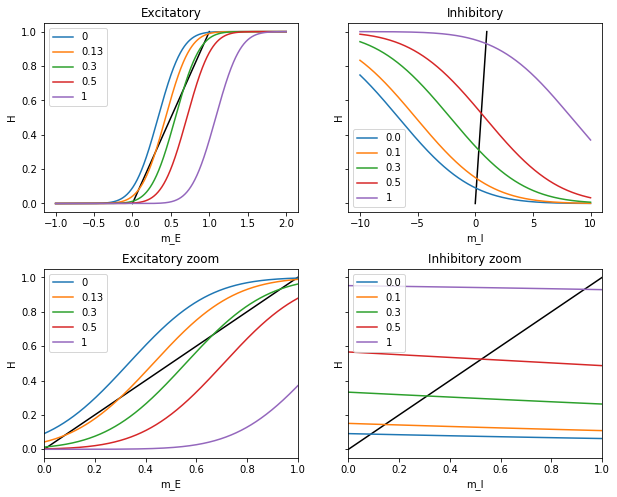

In [4]:
## Figure S17E 
# Here, one population (e.g. m_E) is varied, while the other (e.g. m_I) is kept fixed (simplified by w_EI*m_I = I in their manuscript)
# For both the E population (as shown in Marshel ea) and I population (not shown)
# This figure shows the full H function (sigmoid-like) on top row, and the 0-1 zoom in on bottom row

plt.rcParams['figure.figsize'] = (10, 8)
# plt.subplots_adjust(hspace=0.5, wspace=0.3)
fig, axes = plt.subplots(2, 2, sharey=True, gridspec_kw={'hspace': 0.3, 'wspace': 0.2})

col = 0
extra_title = {0: '', 1: ' zoom'}
for row in [0, 1]:  # very lazy so I compute it twice and zoom in on the second, rather than only computing it once and creating a link 
    axes[row, col].plot([0, 1], [0, 1], color='k')
    h_arr = dict()
    input_x_arry = np.linspace(-1, 2, 2000)
    for inhib_value in [0, 0.13, 0.3, 0.5, 1]:  # inhibitory values to use
        h_arr[inhib_value] = h_function((threshold - u_e(m_e=input_x_arry, m_i=inhib_value)) 
                                        / sigma_0)
        axes[row, col].plot(input_x_arry, h_arr[inhib_value], label=str(inhib_value))
    axes[row, col].set_xlabel('m_E'); axes[row, col].set_ylabel('H'); 
    axes[row, col].set_title('Excitatory' + extra_title[row])
    axes[row, col].legend()
axes[1, 1].set_xlim([0, 1])  # zoom in

col = 1
for row in [0, 1]:  # Lazy so I just copy-pasted for inhibitory and changed relevant variables
    h_arr = dict()
    input_x_arry = np.linspace(-10, 10, 2000)
    
    axes[row, col].plot([0, 1], [0, 1], color='k')
    h_arr = dict()
    for inhib_value in [0.0, 0.1, 0.3, 0.5, 1]:  # excitatory values to use (same param because still lazy)
#     for inhib_value in np.linspace(0, 1, 26):
        h_arr[inhib_value] = h_function((threshold - u_i(m_i=input_x_arry, m_e=inhib_value)) 
                                        / sigma_0)
        axes[row, col].plot(input_x_arry, h_arr[inhib_value], label=str(inhib_value))
    axes[row, col].set_xlabel('m_I'); axes[row, col].set_ylabel('H'); 
    axes[row, col].set_title('Inhibitory'+ extra_title[row])
    axes[row, col].legend()
    
axes[1, 0].set_xlim([0, 1]);

In [5]:
## Now to make the F plot
## The fixed points are computed numerically. 
## Basically, for E, the level of inhibition is varied, and the Fixed points are found numerically
## So you get a functions fixed points (level of inhibition)
## Then the same thing for I, while varying E.
## Takes ~10 secs to run

def find_intersection(fun1, fun2, x0, other_x0):
    """Function that numerically finds intersection between two functions fun1 and fun2"""
    x_coord = scipy.optimize.fsolve(lambda x : fun1(x, other_start_value=other_x0)
                                    - fun2(x),x0)  # solve intersection
    isclose = np.isclose(fun1(x_coord, other_start_value=other_x0), fun2(x_coord))  # find if solution is correct (because scipy will always output sometihgn....)
    if isclose:
        return x_coord
    else:
        return None

def test_fun_i(x, other_start_value): # function for inhib, can only have 1 argument
    return h_function((threshold - u_i(m_i=x, m_e=other_start_value)) 
                                        / sigma_0)

def test_fun_e(x, other_start_value): 
    return h_function((threshold - u_e(m_e=x, m_i=other_start_value)) 
                                        / sigma_0)
    
def test_fun_x(x):
    return x

def find_fps(test_function, n_start=101, n_other_start=501):
    """Function to find intersections with test_function and y(x)=x"""
    other_start_value_arr = np.linspace(0, 1, n_other_start)
    dom_start_value_arr = np.linspace(0, 1, n_start)
    fp_matrix = np.zeros((n_start, n_other_start))  # collect FPs

    for i_other, other_start_value in enumerate(other_start_value_arr): # loop over 2D start values
        for i_start, start_value in enumerate(dom_start_value_arr):
            fp_matrix[i_start, i_other] = find_intersection(test_function, test_fun_x, 
                                                           start_value, other_start_value)

    inds_found_fp = np.logical_not(np.isnan(fp_matrix))  # find all non-nan solutions
    other_val_list = []  # gather them with list construction, because of varying number of FPs
    fp_list = []
    n_fps = np.zeros(len(other_start_value_arr))
    for i_start, start_value in enumerate(other_start_value_arr):
        tmp_fps = list(np.unique(np.round(fp_matrix[inds_found_fp[:, i_start], 
                                                                    i_start], 3)))  # find all unique FPs per value of the fixed mean
        n_fps[i_start] = len(tmp_fps)
        for fp in tmp_fps: # append to listts
            other_val_list.append(start_value)
            fp_list.append(fp)
    other_val_list = np.array(other_val_list)  # transform to np array
    fp_list = np.array(fp_list)
    return other_val_list, fp_list, n_fps

other_val_list_e, fp_list_e, n_fps_e = find_fps(test_fun_e) 
other_val_list_i, fp_list_i, n_fps_i = find_fps(test_fun_i)

# and sort: (sort by m_e value for both)
inds_e = np.argsort(fp_list_e)
other_val_list_e, fp_list_e = other_val_list_e[inds_e], fp_list_e[inds_e]
inds_i = np.argsort(other_val_list_i)
other_val_list_i, fp_list_i = other_val_list_i[inds_i], fp_list_i[inds_i]

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Text(0.5, 1.0, 'Phase portrait; nullclines')

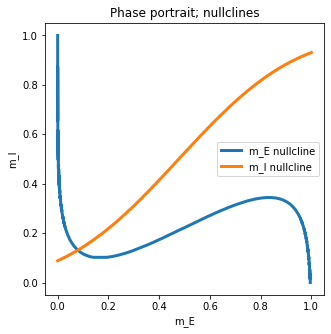

In [6]:
## And plot

plt.rcParams['figure.figsize'] = (5, 5)
plt.plot(fp_list_e, other_val_list_e, '-', linewidth=3, label='m_E nullcline')
plt.plot(other_val_list_i, fp_list_i, '-', linewidth=3, label='m_I nullcline')
plt.xlabel('m_E'); plt.ylabel('m_I'); plt.legend(); plt.title('Phase portrait; nullclines')

In [8]:
## The previous analysis just found the subplots, now we actually simulate the mean field model
## We will see that wherever you start (in m_E, m_I -space), you always end up in the 
## joint fixed point. 
## Id est, inhibition will slowly catch up with excitation and bring the entire system to
## a balance.

## This cell just defines the function, the next cell actually runs it

def run_m_ei(m_e0, m_i0, e_fixed=False, i_fixed=False, 
             time_points=100, noise_sigma=0.02):
    m_e_arr = np.zeros(time_points)
    m_i_arr = np.zeros(time_points)

    m_e_arr[0] = m_e0
    m_i_arr[0] = m_i0
    for t in range(1, time_points):
        if i_fixed:
            old_m_i = m_i0
        else:
            old_m_i = m_i_arr[t - 1]
            
        if e_fixed:
            old_m_e = m_e0
        else:
            old_m_e = m_e_arr[t - 1]
            
        if e_fixed is False:
            m_e_arr[t] = h_function((threshold - u_e(m_e=old_m_e, m_i=old_m_i))
                                    / sigma_0)
            m_e_arr[t] += np.random.randn() * noise_sigma
        else:
            m_e_arr[t] = m_e0
            
        if i_fixed is False:
            m_i_arr[t] = h_function((threshold - u_i(m_e=old_m_e, m_i=old_m_i))
                                    / sigma_0)
            m_i_arr[t] += np.random.randn() * noise_sigma
        else:
            m_i_arr[t] = m_i0
            
    return m_e_arr, m_i_arr

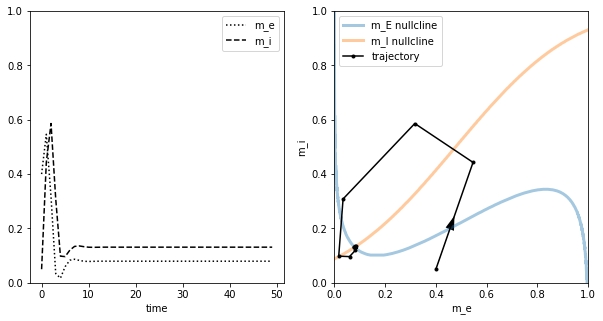

In [10]:
## Run a simulation (you can change the starting points m_e0 and m_i0)

m_e_arr, m_i_arr = run_m_ei(m_e0=0.4, m_i0=0.05, e_fixed=False, i_fixed=False, 
                            time_points=50, noise_sigma=0.0)


## Plot

plt.rcParams['figure.figsize'] = ( 10, 5)

plt.subplot(121)
plt.plot(m_e_arr, ':', c='k', label='m_e')
plt.plot(m_i_arr, '--', c='k', label='m_i')
plt.legend(); plt.xlabel('time')
plt.ylim([0, 1])

plt.subplot(122)
plt.plot(fp_list_e, other_val_list_e, '-', linewidth=3, alpha=0.4, label='m_E nullcline')
plt.plot(other_val_list_i, fp_list_i, '-', linewidth=3, alpha=0.4, label='m_I nullcline')
plt.plot(m_e_arr, m_i_arr, '.-', c='k', label='trajectory')
plt.arrow(m_e_arr[0], m_i_arr[0], np.diff(m_e_arr)[0] / 2, np.diff(m_i_arr)[0] / 2, 
         length_includes_head=True, head_width=0.035, shape='full', lw=0, **{'color': 'k'})
plt.xlabel('m_e'); plt.ylabel('m_i')
plt.xlim([0, 1]); plt.ylim([0, 1]); plt.legend()